참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

In [3]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 37.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 29.4 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=7e3031eab9eef4065ab7b309c41479624e9e7c6fe94a49b8a1d1864250d48817
  Stored in directory: /root/.cache/pip/wheels/a0/56/2c/eac72592ca2e80bdc46ff47d1fb327629e2a24e8cdc5aaf95f
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   486k      0  0:00:02  0:00:02 --:--:--  901k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/exam

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [8]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [9]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [10]:
train_data['label'].value_counts()

,count
label,
1,80003
0,79923


### 데이터 정제 및 전처리

In [11]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

<ipython-input-11-b3393058b13d>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True)
<ipython-input-11-b3393058b13d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

### 토큰화

In [14]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open('/content/drive/MyDrive/KUBIG25/WEEK3/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

### 정수 인코딩

In [15]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [16]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [17]:
# vocab_size 설정
vocab_size = len(tokenizer.word_index)

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 패딩




In [18]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 17.15400872903718


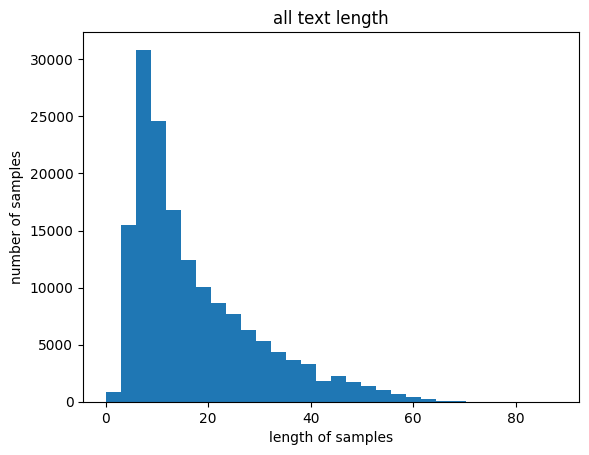

In [19]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9337005865212661


In [21]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### 퀴즈

문제: 패딩을 하는 이유는 무엇일까요? (어떤 경우에 사용하는지 생각해보세요)

답변: 패딩을 하지 않고 각기 다른 길이의 샘플들을 매번 모델에 학습시키려고 한다면, 매번 모델의 input 차원이 달라지게 되고 모델 구조 자체가 변경되어야 한다. 이를 방지하기 위해 적절한 인풋 데이터의 길이를 지정하고 그에 못미치는 데이터에 대해서는 빈 데이터를 패딩으로 채워주는 방법을 사용하는 것이다.

In [22]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

### DataLoader 생성

In [26]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [27]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 모델 학습 (Vanilla RNN)

In [30]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach())

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :] # 64 x 64 size

        """
        문제 1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)    #output 차원으로 변환하는 fully connected layer를 통과 시킴
        return out

In [31]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)


"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요
"""
criterion = nn.CrossEntropyLoss()   #이진 분류 문제이므로 crossentropyloss 활용

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [32]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels)    #손실 함수

        loss.backward()

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step()    #가중치 업데이트

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.24841579794883728. Accuracy: 88.1021499633789
Iteration: 1000. Loss: 0.23849378526210785. Accuracy: 87.71196746826172
Iteration: 1500. Loss: 0.1930086612701416. Accuracy: 87.351806640625
Iteration: 2000. Loss: 0.24868620932102203. Accuracy: 89.15011596679688
Iteration: 2500. Loss: 0.2744455635547638. Accuracy: 88.0121078491211
Iteration: 3000. Loss: 0.4361954927444458. Accuracy: 81.58171081542969
Iteration: 3500. Loss: 0.39300909638404846. Accuracy: 84.63058471679688
Iteration: 4000. Loss: 0.303879976272583. Accuracy: 87.55940246582031
Iteration: 4500. Loss: 0.31959784030914307. Accuracy: 88.04962158203125
Iteration: 5000. Loss: 0.4610462784767151. Accuracy: 86.36386108398438
Iteration: 5500. Loss: 0.13870684802532196. Accuracy: 88.40228271484375
Iteration: 6000. Loss: 0.27153894305229187. Accuracy: 85.5459976196289
Iteration: 6500. Loss: 0.37435832619667053. Accuracy: 87.7719955444336
Iteration: 7000. Loss: 0.3485049605369568. Accuracy: 87.20924377441406
Iterat

In [41]:
#epoch=10
num_epoch = 10
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)


"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요
"""
criterion = nn.CrossEntropyLoss()   #이진 분류 문제이므로 crossentropyloss 활용

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [42]:
#epoch=10
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels)    #손실 함수

        loss.backward()

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step()    #가중치 업데이트

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.3536786139011383. Accuracy: 87.21424865722656
Iteration: 1000. Loss: 0.3705340325832367. Accuracy: 88.51483154296875
Iteration: 1500. Loss: 0.4630501866340637. Accuracy: 88.45980834960938
Iteration: 2000. Loss: 0.33675041794776917. Accuracy: 89.3977279663086
Iteration: 2500. Loss: 0.19017867743968964. Accuracy: 89.59031677246094
Iteration: 3000. Loss: 0.20115169882774353. Accuracy: 89.13011169433594
Iteration: 3500. Loss: 0.4131123721599579. Accuracy: 89.95047760009766
Iteration: 4000. Loss: 0.14870716631412506. Accuracy: 89.44775390625
Iteration: 4500. Loss: 0.42723992466926575. Accuracy: 89.68785858154297
Iteration: 5000. Loss: 0.22925834357738495. Accuracy: 89.52528381347656
Iteration: 5500. Loss: 0.23063305020332336. Accuracy: 87.7770004272461
Iteration: 6000. Loss: 0.2064984142780304. Accuracy: 88.48982238769531
Iteration: 6500. Loss: 0.18408085405826569. Accuracy: 89.58031463623047
Iteration: 7000. Loss: 0.2592915892601013. Accuracy: 89.785400390625
Iterat

### 모델학습 (LSTM, Long short term memory)

In [33]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [34]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [35]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.20775234699249268. Accuracy: 90.74333190917969
Iteration: 2000. Loss: 0.38271281123161316. Accuracy: 91.73628234863281
Iteration: 3000. Loss: 0.15180574357509613. Accuracy: 91.71127319335938
Iteration: 4000. Loss: 0.29380425810813904. Accuracy: 91.65374755859375
Iteration: 5000. Loss: 0.2621970474720001. Accuracy: 91.9313735961914
Iteration: 6000. Loss: 0.21583706140518188. Accuracy: 91.58871459960938
Iteration: 7000. Loss: 0.1271146833896637. Accuracy: 91.73628234863281
Iteration: 8000. Loss: 0.1092834621667862. Accuracy: 91.31359100341797
Iteration: 9000. Loss: 0.038239650428295135. Accuracy: 91.3386001586914
Iteration: 10000. Loss: 0.08360294997692108. Accuracy: 91.40113067626953
Iteration: 11000. Loss: 0.09846203774213791. Accuracy: 91.3486099243164
Iteration: 12000. Loss: 0.04869462177157402. Accuracy: 91.15602111816406
Iteration: 13000. Loss: 0.08204793184995651. Accuracy: 90.94342803955078
Iteration: 14000. Loss: 0.29569804668426514. Accuracy: 90.8033599

In [45]:
#hidden_dim=32
num_epoch = 15
batch_size = 64
embedding_dim = 32
hidden_dim = 32
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [46]:
#hidden_dim=32
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.21145987510681152. Accuracy: 90.2506103515625
Iteration: 2000. Loss: 0.29153499007225037. Accuracy: 91.3661117553711
Iteration: 3000. Loss: 0.2903038263320923. Accuracy: 91.57120513916016
Iteration: 4000. Loss: 0.16687074303627014. Accuracy: 91.74128723144531
Iteration: 5000. Loss: 0.1104164645075798. Accuracy: 91.90385437011719
Iteration: 6000. Loss: 0.0969446450471878. Accuracy: 91.6062240600586
Iteration: 7000. Loss: 0.28996050357818604. Accuracy: 91.56871032714844
Iteration: 8000. Loss: 0.08145210891962051. Accuracy: 91.38862609863281
Iteration: 9000. Loss: 0.09471919387578964. Accuracy: 91.67375183105469
Iteration: 10000. Loss: 0.10161316394805908. Accuracy: 91.50617980957031
Iteration: 11000. Loss: 0.2300911545753479. Accuracy: 91.0634765625
Iteration: 12000. Loss: 0.3825637102127075. Accuracy: 91.30609130859375
Iteration: 13000. Loss: 0.07828477770090103. Accuracy: 91.17852783203125
Iteration: 14000. Loss: 0.05790677294135094. Accuracy: 90.950927734375
I

### 모델 학습 (Gated Recurrent Unit (GRU))

In [36]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [37]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [38]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.19558772444725037. Accuracy: 90.68580627441406
Iteration: 2000. Loss: 0.22719363868236542. Accuracy: 91.55120086669922
Iteration: 3000. Loss: 0.2681664526462555. Accuracy: 91.62123107910156
Iteration: 4000. Loss: 0.12318985164165497. Accuracy: 91.646240234375
Iteration: 5000. Loss: 0.17851264774799347. Accuracy: 91.68875885009766
Iteration: 6000. Loss: 0.15007609128952026. Accuracy: 91.3711166381836
Iteration: 7000. Loss: 0.10040678083896637. Accuracy: 91.49867248535156
Iteration: 8000. Loss: 0.15727393329143524. Accuracy: 91.33360290527344
Iteration: 9000. Loss: 0.1385948359966278. Accuracy: 91.01345825195312
Iteration: 10000. Loss: 0.103005051612854. Accuracy: 91.33360290527344
Iteration: 11000. Loss: 0.12225305289030075. Accuracy: 91.07598876953125
Iteration: 12000. Loss: 0.2374206930398941. Accuracy: 91.03596496582031
Iteration: 13000. Loss: 0.27112945914268494. Accuracy: 90.94342803955078
Iteration: 14000. Loss: 0.03304268419742584. Accuracy: 90.5182342529

In [47]:
#hidden_dim=32
num_epoch = 15
batch_size = 64
embedding_dim = 32
hidden_dim = 32
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [48]:
#hiddem_dim=32
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.1598825752735138. Accuracy: 90.36066436767578
Iteration: 2000. Loss: 0.2289312779903412. Accuracy: 91.2635726928711
Iteration: 3000. Loss: 0.2645832896232605. Accuracy: 91.16852569580078
Iteration: 4000. Loss: 0.21800266206264496. Accuracy: 91.40863800048828
Iteration: 5000. Loss: 0.19340889155864716. Accuracy: 91.59371948242188
Iteration: 6000. Loss: 0.12277243286371231. Accuracy: 91.38862609863281
Iteration: 7000. Loss: 0.12865380942821503. Accuracy: 91.45365142822266
Iteration: 8000. Loss: 0.17397941648960114. Accuracy: 91.09599304199219
Iteration: 9000. Loss: 0.09997517615556717. Accuracy: 91.24105834960938
Iteration: 10000. Loss: 0.1507621705532074. Accuracy: 91.2210464477539
Iteration: 11000. Loss: 0.18622960150241852. Accuracy: 90.97593688964844
Iteration: 12000. Loss: 0.3138495981693268. Accuracy: 90.98844909667969
Iteration: 13000. Loss: 0.09450192004442215. Accuracy: 90.87589263916016
Iteration: 14000. Loss: 0.2662278115749359. Accuracy: 90.7633438110

In [51]:
#hidden_dim=128
num_epoch = 10
batch_size = 64
embedding_dim = 128
hidden_dim = 128
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [52]:
#hiddem_dim=128
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.21610204875469208. Accuracy: 91.03846740722656
Iteration: 2000. Loss: 0.33240464329719543. Accuracy: 91.0284652709961
Iteration: 3000. Loss: 0.2848777770996094. Accuracy: 91.39363098144531
Iteration: 4000. Loss: 0.1612108200788498. Accuracy: 91.27857971191406
Iteration: 5000. Loss: 0.06800428777933121. Accuracy: 91.22354888916016
Iteration: 6000. Loss: 0.08354531973600388. Accuracy: 91.12850952148438
Iteration: 7000. Loss: 0.26554998755455017. Accuracy: 91.36861419677734
Iteration: 8000. Loss: 0.153072327375412. Accuracy: 90.96343231201172
Iteration: 9000. Loss: 0.2108405977487564. Accuracy: 90.72832489013672
Iteration: 10000. Loss: 0.23404979705810547. Accuracy: 90.39817810058594
Iteration: 11000. Loss: 0.3956398069858551. Accuracy: 90.07803344726562
Iteration: 12000. Loss: 0.2999671399593353. Accuracy: 88.9775390625
Iteration: 13000. Loss: 0.2887752056121826. Accuracy: 89.18263244628906
Iteration: 14000. Loss: 0.29251131415367126. Accuracy: 88.6799087524414
I

## 모델 성능 비교

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!

# Step 1.
우선 기본 베이스라인 코드대로 실행을 해보았을 때는 세 모델 모두 iteration이 반복될 수록 accuracy가 낮아지며 과적합이 발생하는 현상을 확인할 수 있었다.

VanillaRNN의 경우에는 24500 즈음의 iteration에서 최고 accuracy인 89.4 정도를 기록하고 하향세를 보였다. 따라서 epoch수를 줄이는 조치를 취해 보았다.

하지만 나머지 두 모델은 비교적 아주 이른 시점부터 accuracy가 감소하기 시작하는 것으로 보아 모델 자체가 복잡하다고 느껴서 hidden layer의 차원을 줄이는 방법을 시도해보았다.

# Step 2.
VanillaRNN의 epoch수를 줄인 결과 최종 모델의 성능이 이전에 비해 향상된 것을 확인할 수 있었다.

LSTM은 차원을 낮추었을 때, 크게 향상되지는 않았지만 근소하게나마 전체적인 정확도가 올라간 것을 확인할 수 있었다.

GRU는 차원을 낮추었을 때, 오히려 성능이 떨어진 것을 확인할 수 있었다.

LSTM과 GRU 모두 iteration이 많아질수록 전체적인 accuracy가 감소하는 양상은 여전히 유지되는 점을 확인하였다. 그래서 마지막으로 GRU는 차원을 더 올리고, epoch 수는 줄여주고 한 번 더 모델을 돌려보았다.

# Step 3.

hidden_dim을 128까지 올렸을 때, 초반에는 이전의 설정들과 크게 다르지 않다가, iteration이 반복될 수록 loss가 아주 커지는 것을 확인하였다.

최종적으로, hidden_dim의 경우, baseline으로 설정했던 64가 최적의 값이고, accuracy만으로 모델의 성능을 비교해 보았을 때, epoch을 많이 줄여주어야 모델 성능이 올라가는 것을 확인할 수 있었다.

VanillaRNN보다는 LSTM과 GRU의 성능이 더 높은 것을 확인할 수 있었다.